# EMA and SWA Robustness Analysis

This notebook analyzes the robustness of EMA (Exponential Moving Average) and SWA (Stochastic Weight Averaging) models compared to the baseline.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
plt.style.use("style.mplstyle")

## 1. Load and Display Raw Data

In [3]:
# Load EMA/SWA results
df = pd.read_parquet("../analysis/ema_swa_robustness_results.parquet")
df

,run_id,seed,model_type,clean_acc,clean_loss,corrupted_acc,corrupted_loss
0,0,42,Baseline,78.39,1.022124,50.882105,2.368694
1,0,42,EMA,78.54,1.008187,51.020000,2.356520
2,0,42,SWA,79.84,0.903511,54.047895,2.633997
3,1,43,Baseline,78.04,1.030126,50.819474,2.353889
4,1,43,EMA,78.17,1.020017,51.127368,2.340402
5,1,43,SWA,79.81,0.874004,54.470526,2.512794
6,2,44,Baseline,78.87,0.997725,51.312105,2.357207
7,2,44,EMA,79.19,0.986762,51.860526,2.323898
8,2,44,SWA,80.64,0.862132,55.261579,2.566294
9,3,45,Baseline,78.57,1.003221,50.760000,2.392352


In [10]:
# Distill to just baseline and SWA results and 2 digit decimal places for readability
df_compact = df[df["model_type"].isin(["Baseline", "SWA"])]
# round  clean_loss	corrupted_acc	corrupted_loss
df_compact = df_compact.round(
    {
        "clean_loss": 2,
        "corrupted_acc": 2,
        "corrupted_loss": 2,
    }
)
df_compact

# export to CSV
df_compact.to_csv("../analysis/ema_swa_robustness_results_compact.csv", index=False)

## 2. Aggregate Statistics Across Runs

Compute mean and standard deviation for each model type across all runs.

In [5]:
# Group by model type and compute mean/std
stats = df.groupby('model_type').agg(
    clean_acc_mean=('clean_acc', 'mean'),
    clean_acc_std=('clean_acc', 'std'),
    clean_loss_mean=('clean_loss', 'mean'),
    clean_loss_std=('clean_loss', 'std'),
    corrupted_acc_mean=('corrupted_acc', 'mean'),
    corrupted_acc_std=('corrupted_acc', 'std'),
    corrupted_loss_mean=('corrupted_loss', 'mean'),
    corrupted_loss_std=('corrupted_loss', 'std'),
    n_runs=('run_id', 'count')
).round(4)

stats

,clean_acc_mean,clean_acc_std,clean_loss_mean,clean_loss_std,corrupted_acc_mean,corrupted_acc_std,corrupted_loss_mean,corrupted_loss_std,n_runs
model_type,,,,,,,,,
Baseline,78.4375,0.3033,1.0146,0.0110,51.1881,0.4303,2.3530,0.0268,12
EMA,78.6017,0.3137,1.0022,0.0102,51.4455,0.4509,2.3367,0.0246,12
SWA,80.0217,0.3293,0.8835,0.0126,54.8625,0.6036,2.5613,0.0605,12


In [6]:
# Format as mean +/- std for cleaner display
summary = pd.DataFrame({
    'Model': stats.index,
    'Clean Acc': [f"{m:.2f} ± {s:.2f}" for m, s in zip(stats['clean_acc_mean'], stats['clean_acc_std'])],
    'Clean Loss': [f"{m:.4f} ± {s:.4f}" for m, s in zip(stats['clean_loss_mean'], stats['clean_loss_std'])],
    'Corrupted Acc': [f"{m:.2f} ± {s:.2f}" for m, s in zip(stats['corrupted_acc_mean'], stats['corrupted_acc_std'])],
    'Corrupted Loss': [f"{m:.4f} ± {s:.4f}" for m, s in zip(stats['corrupted_loss_mean'], stats['corrupted_loss_std'])],
    'N Runs': stats['n_runs'].values
}).set_index('Model')

# Reorder to show Baseline first
summary = summary.reindex(['Baseline', 'EMA', 'SWA'])
summary

,Clean Acc,Clean Loss,Corrupted Acc,Corrupted Loss,N Runs
Model,,,,,
Baseline,78.44 ± 0.30,1.0146 ± 0.0110,51.19 ± 0.43,2.3530 ± 0.0268,12
EMA,78.60 ± 0.31,1.0022 ± 0.0102,51.45 ± 0.45,2.3367 ± 0.0246,12
SWA,80.02 ± 0.33,0.8835 ± 0.0126,54.86 ± 0.60,2.5613 ± 0.0605,12


## 3. Compute Gains Over Baseline

For each run, compute the gain of EMA and SWA over the baseline for both clean and corrupted metrics.

In [7]:
# Pivot to have model types as columns for each run
pivot = df.pivot(index=['run_id', 'seed'], columns='model_type', values=['clean_acc', 'clean_loss', 'corrupted_acc', 'corrupted_loss'])
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.reset_index()

# Compute gains (positive = improvement)
# For accuracy: EMA/SWA - Baseline (higher is better)
# For loss: Baseline - EMA/SWA (lower is better, so gain = baseline - model)
pivot['ema_clean_acc_gain'] = pivot['clean_acc_EMA'] - pivot['clean_acc_Baseline']
pivot['ema_clean_loss_gain'] = pivot['clean_loss_Baseline'] - pivot['clean_loss_EMA']
pivot['ema_corrupted_acc_gain'] = pivot['corrupted_acc_EMA'] - pivot['corrupted_acc_Baseline']
pivot['ema_corrupted_loss_gain'] = pivot['corrupted_loss_Baseline'] - pivot['corrupted_loss_EMA']

pivot['swa_clean_acc_gain'] = pivot['clean_acc_SWA'] - pivot['clean_acc_Baseline']
pivot['swa_clean_loss_gain'] = pivot['clean_loss_Baseline'] - pivot['clean_loss_SWA']
pivot['swa_corrupted_acc_gain'] = pivot['corrupted_acc_SWA'] - pivot['corrupted_acc_Baseline']
pivot['swa_corrupted_loss_gain'] = pivot['corrupted_loss_Baseline'] - pivot['corrupted_loss_SWA']

pivot

,run_id,seed,clean_acc_Baseline,clean_acc_EMA,clean_acc_SWA,clean_loss_Baseline,clean_loss_EMA,clean_loss_SWA,corrupted_acc_Baseline,corrupted_acc_EMA,...,corrupted_loss_EMA,corrupted_loss_SWA,ema_clean_acc_gain,ema_clean_loss_gain,ema_corrupted_acc_gain,ema_corrupted_loss_gain,swa_clean_acc_gain,swa_clean_loss_gain,swa_corrupted_acc_gain,swa_corrupted_loss_gain
0,0,42,78.39,78.54,79.84,1.022124,1.008187,0.903511,50.882105,51.020000,...,2.356520,2.633997,0.15,0.013936,0.137895,0.012174,1.45,0.118613,3.165789,-0.265303
1,1,43,78.04,78.17,79.81,1.030126,1.020017,0.874004,50.819474,51.127368,...,2.340402,2.512794,0.13,0.010109,0.307895,0.013487,1.77,0.156122,3.651053,-0.158905
2,2,44,78.87,79.19,80.64,0.997725,0.986762,0.862132,51.312105,51.860526,...,2.323898,2.566294,0.32,0.010963,0.548421,0.033309,1.77,0.135593,3.949474,-0.209087
3,3,45,78.57,78.85,80.18,1.003221,0.990375,0.862645,50.760000,51.307895,...,2.359612,2.596154,0.28,0.012846,0.547895,0.032740,1.61,0.140576,3.832105,-0.203803
4,4,46,78.04,78.14,79.42,1.016538,1.005864,0.889217,51.064211,50.817368,...,2.363573,2.567812,0.10,0.010674,-0.246842,-0.018387,1.38,0.127321,3.394211,-0.222625
5,5,47,78.47,78.73,80.38,1.013501,0.998311,0.881549,51.514737,51.626316,...,2.337781,2.561708,0.26,0.015190,0.111579,0.007503,1.91,0.131952,3.762632,-0.216425
6,6,48,78.21,78.33,79.85,1.020734,1.005742,0.897073,50.365789,50.876316,...,2.363883,2.619431,0.12,0.014993,0.510526,0.034364,1.64,0.123661,3.927368,-0.221183
7,7,49,78.57,78.79,80.27,1.006069,0.993052,0.881309,51.620000,52.243684,...,2.286313,2.443055,0.22,0.013017,0.623684,0.040743,1.70,0.124760,4.427895,-0.115998
8,8,50,78.97,78.90,79.88,0.999836,0.992239,0.889832,51.585263,51.863684,...,2.327208,2.557618,-0.07,0.007597,0.278421,0.012301,0.91,0.110004,3.413684,-0.218110
9,9,51,78.09,78.38,79.87,1.031206,1.015142,0.891307,51.516842,51.380000,...,2.325438,2.523355,0.29,0.016064,-0.136842,-0.003041,1.78,0.139899,3.735789,-0.200957


In [8]:
# Summarize gains
gain_cols = [
    'ema_clean_acc_gain', 'ema_clean_loss_gain', 'ema_corrupted_acc_gain', 'ema_corrupted_loss_gain',
    'swa_clean_acc_gain', 'swa_clean_loss_gain', 'swa_corrupted_acc_gain', 'swa_corrupted_loss_gain'
]

gain_stats = pivot[gain_cols].agg(['mean', 'std']).T
gain_stats['formatted'] = [f"{m:.4f} ± {s:.4f}" for m, s in zip(gain_stats['mean'], gain_stats['std'])]
gain_stats

,mean,std,formatted
ema_clean_acc_gain,0.164167,0.120110,0.1642 ± 0.1201
ema_clean_loss_gain,0.012413,0.002443,0.0124 ± 0.0024
ema_corrupted_acc_gain,0.257368,0.276329,0.2574 ± 0.2763
ema_corrupted_loss_gain,0.016328,0.017239,0.0163 ± 0.0172
swa_clean_acc_gain,1.584167,0.270100,1.5842 ± 0.2701
swa_clean_loss_gain,0.131054,0.011828,0.1311 ± 0.0118
swa_corrupted_acc_gain,3.674342,0.356367,3.6743 ± 0.3564
swa_corrupted_loss_gain,-0.208283,0.043156,-0.2083 ± 0.0432


## 4. Robustness Gap Analysis

Robustness gap = Clean accuracy - Corrupted accuracy

A smaller gap indicates better robustness (the model degrades less under corruption).

In [9]:
# Compute robustness gap for each model type per run
pivot['baseline_robustness_gap'] = pivot['clean_acc_Baseline'] - pivot['corrupted_acc_Baseline']
pivot['ema_robustness_gap'] = pivot['clean_acc_EMA'] - pivot['corrupted_acc_EMA']
pivot['swa_robustness_gap'] = pivot['clean_acc_SWA'] - pivot['corrupted_acc_SWA']

# Also compute using loss (more common in the other notebooks)
pivot['baseline_robustness_gap_loss'] = pivot['corrupted_loss_Baseline'] - pivot['clean_loss_Baseline']
pivot['ema_robustness_gap_loss'] = pivot['corrupted_loss_EMA'] - pivot['clean_loss_EMA']
pivot['swa_robustness_gap_loss'] = pivot['corrupted_loss_SWA'] - pivot['clean_loss_SWA']

In [10]:
# Summarize robustness gaps
robustness_gap_cols = ['baseline_robustness_gap', 'ema_robustness_gap', 'swa_robustness_gap']
robustness_loss_cols = ['baseline_robustness_gap_loss', 'ema_robustness_gap_loss', 'swa_robustness_gap_loss']

robustness_stats = pivot[robustness_gap_cols].agg(['mean', 'std']).T
robustness_stats.index = ['Baseline', 'EMA', 'SWA']
robustness_stats.columns = ['Gap Mean (Acc)', 'Gap Std (Acc)']

robustness_loss_stats = pivot[robustness_loss_cols].agg(['mean', 'std']).T
robustness_loss_stats.index = ['Baseline', 'EMA', 'SWA']
robustness_loss_stats.columns = ['Gap Mean (Loss)', 'Gap Std (Loss)']

robustness_combined = pd.concat([robustness_stats, robustness_loss_stats], axis=1).round(4)
robustness_combined

,Gap Mean (Acc),Gap Std (Acc),Gap Mean (Loss),Gap Std (Loss)
Baseline,27.2494,0.4057,1.3384,0.0295
EMA,27.1562,0.3193,1.3345,0.0242
SWA,25.1592,0.4715,1.6777,0.0581


In [11]:
# Compute improvement in robustness gap compared to baseline
# Negative means the gap is smaller (better robustness)
pivot['ema_robustness_improvement'] = pivot['baseline_robustness_gap'] - pivot['ema_robustness_gap']
pivot['swa_robustness_improvement'] = pivot['baseline_robustness_gap'] - pivot['swa_robustness_gap']

improvement_stats = pivot[['ema_robustness_improvement', 'swa_robustness_improvement']].agg(['mean', 'std']).T
improvement_stats.index = ['EMA vs Baseline', 'SWA vs Baseline']
improvement_stats['formatted'] = [f"{m:.4f} ± {s:.4f}" for m, s in zip(improvement_stats['mean'], improvement_stats['std'])]
print("Robustness Gap Improvement (positive = smaller gap = better robustness):")
improvement_stats

Robustness Gap Improvement (positive = smaller gap = better robustness):


,mean,std,formatted
EMA vs Baseline,0.093202,0.276453,0.0932 ± 0.2765
SWA vs Baseline,2.090175,0.303462,2.0902 ± 0.3035


## 5. Visualizations

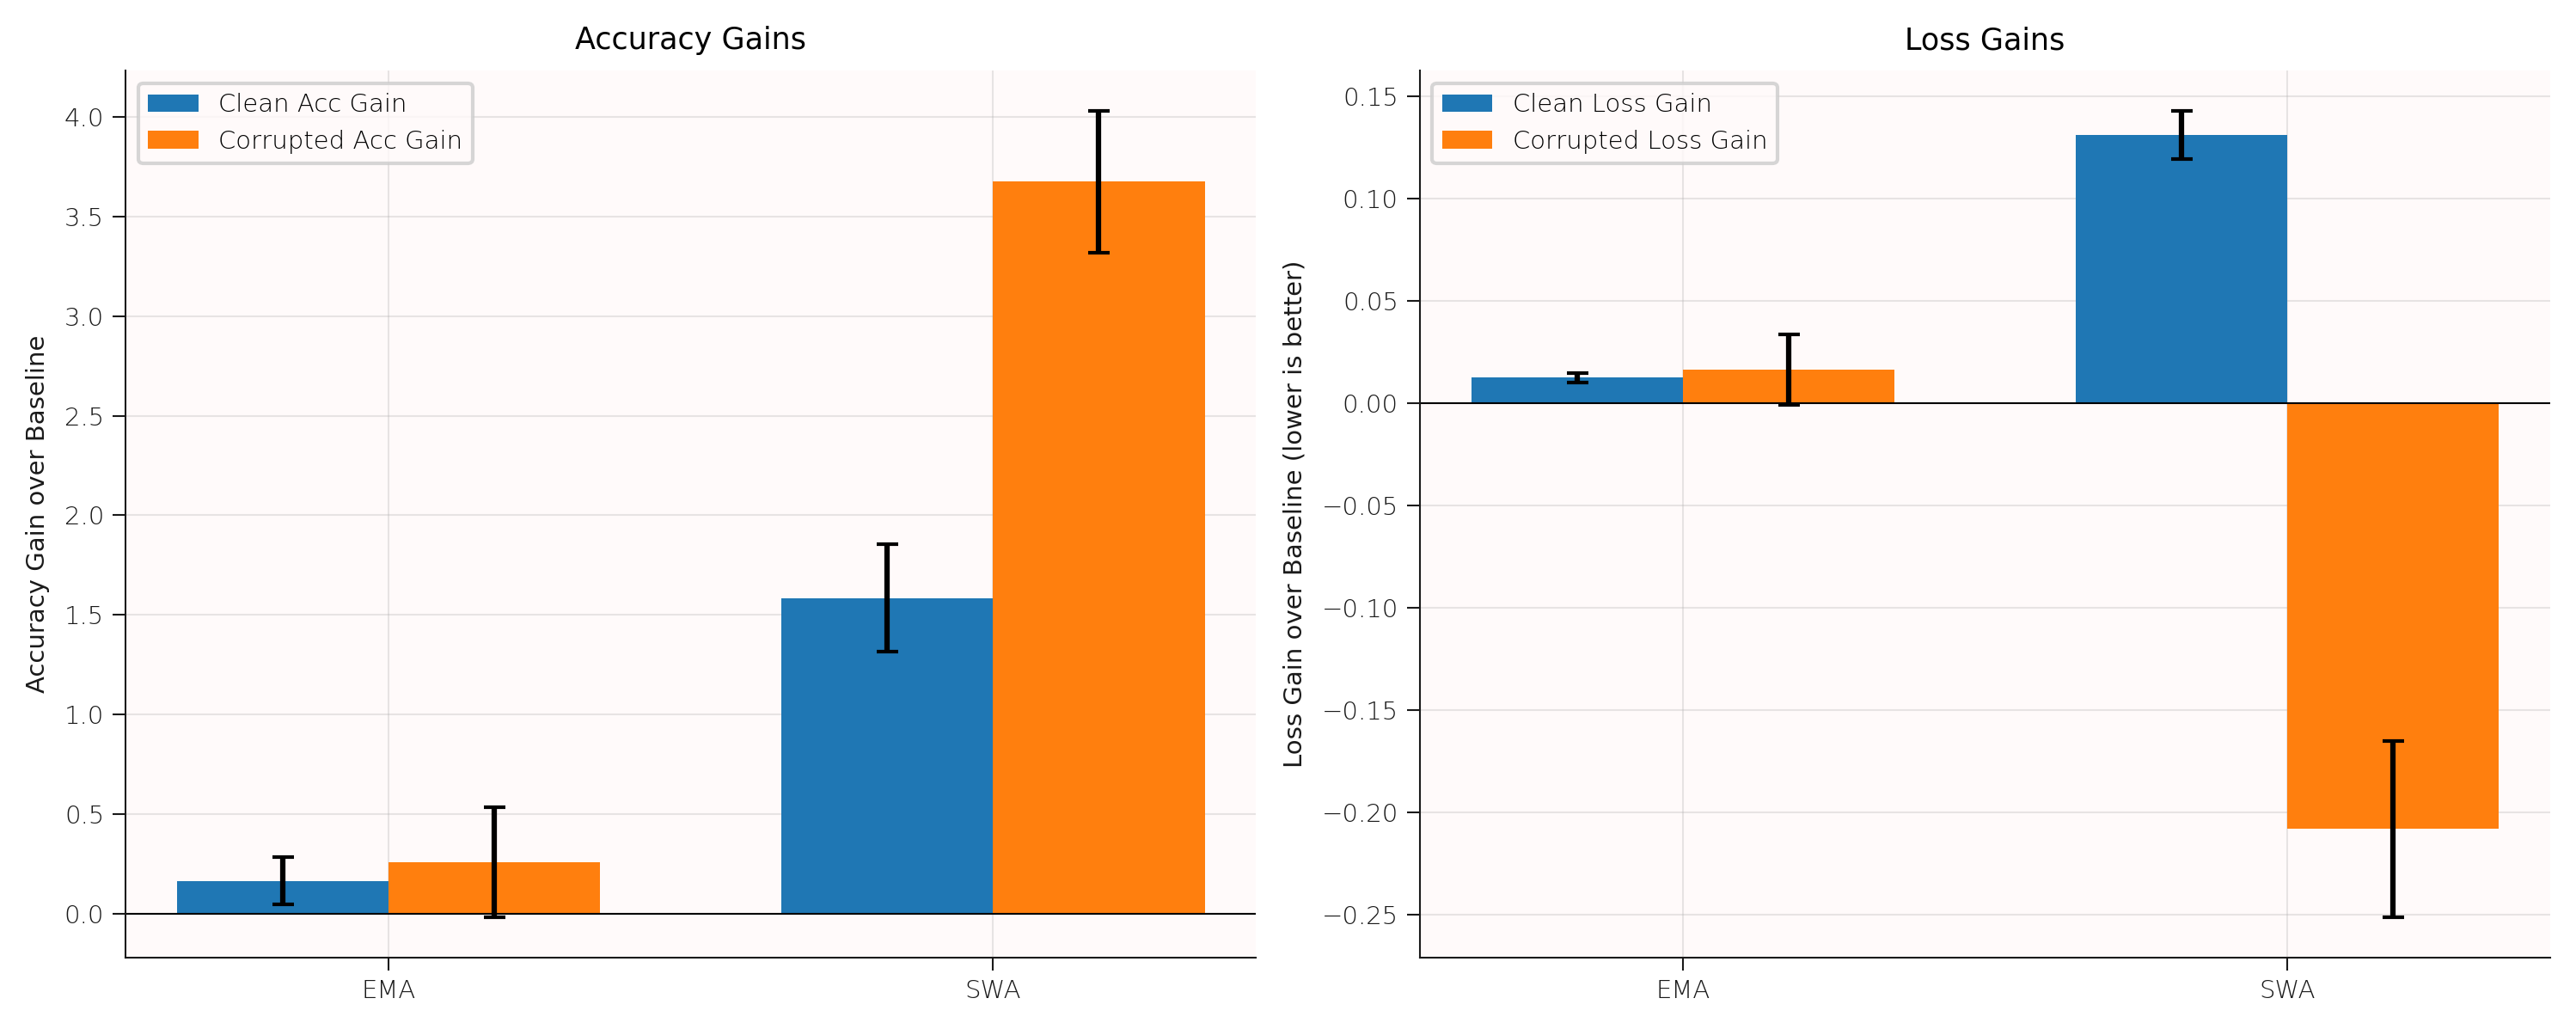

In [12]:
# Bar plot comparing clean vs corrupted gains for EMA and SWA
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy gains
ax = axes[0]
x = np.arange(2)
width = 0.35

clean_gains = [pivot['ema_clean_acc_gain'].mean(), pivot['swa_clean_acc_gain'].mean()]
clean_stds = [pivot['ema_clean_acc_gain'].std(), pivot['swa_clean_acc_gain'].std()]
corrupted_gains = [pivot['ema_corrupted_acc_gain'].mean(), pivot['swa_corrupted_acc_gain'].mean()]
corrupted_stds = [pivot['ema_corrupted_acc_gain'].std(), pivot['swa_corrupted_acc_gain'].std()]

bars1 = ax.bar(x - width/2, clean_gains, width, yerr=clean_stds, label='Clean Acc Gain', capsize=3)
bars2 = ax.bar(x + width/2, corrupted_gains, width, yerr=corrupted_stds, label='Corrupted Acc Gain', capsize=3)

ax.set_ylabel('Accuracy Gain over Baseline')
ax.set_xticks(x)
ax.set_xticklabels(['EMA', 'SWA'])
ax.legend()
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.set_title('Accuracy Gains')
ax.grid(True, alpha=0.3)

# Loss gains
ax = axes[1]
clean_loss_gains = [pivot['ema_clean_loss_gain'].mean(), pivot['swa_clean_loss_gain'].mean()]
clean_loss_stds = [pivot['ema_clean_loss_gain'].std(), pivot['swa_clean_loss_gain'].std()]
corrupted_loss_gains = [pivot['ema_corrupted_loss_gain'].mean(), pivot['swa_corrupted_loss_gain'].mean()]
corrupted_loss_stds = [pivot['ema_corrupted_loss_gain'].std(), pivot['swa_corrupted_loss_gain'].std()]

bars1 = ax.bar(x - width/2, clean_loss_gains, width, yerr=clean_loss_stds, label='Clean Loss Gain', capsize=3)
bars2 = ax.bar(x + width/2, corrupted_loss_gains, width, yerr=corrupted_loss_stds, label='Corrupted Loss Gain', capsize=3)

ax.set_ylabel('Loss Gain over Baseline (lower is better)')
ax.set_xticks(x)
ax.set_xticklabels(['EMA', 'SWA'])
ax.legend()
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.set_title('Loss Gains')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../report/figures/ema_swa_gains.png', dpi=300)
plt.show()

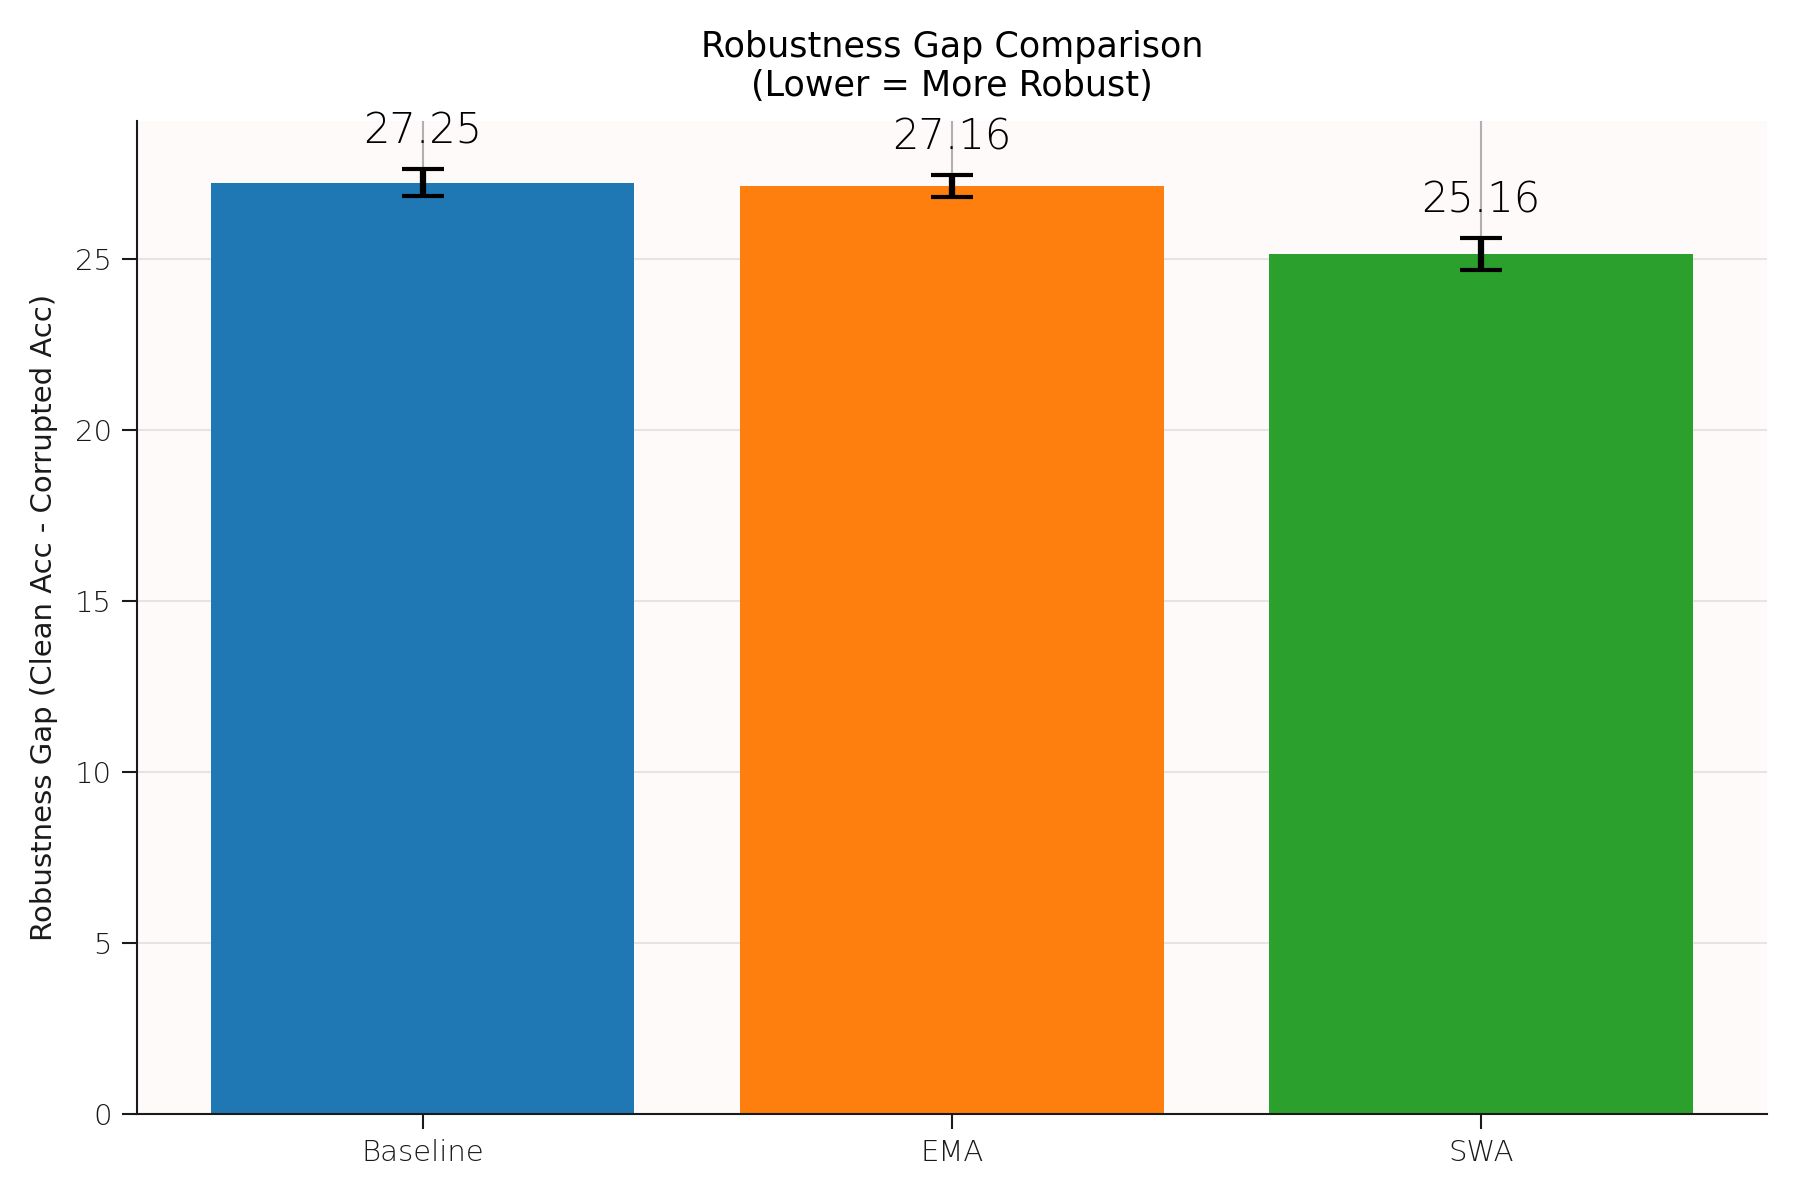

In [13]:
# Robustness gap comparison
fig, ax = plt.subplots(figsize=(6, 4))

models = ['Baseline', 'EMA', 'SWA']
gaps = [
    pivot['baseline_robustness_gap'].mean(),
    pivot['ema_robustness_gap'].mean(),
    pivot['swa_robustness_gap'].mean()
]
gap_stds = [
    pivot['baseline_robustness_gap'].std(),
    pivot['ema_robustness_gap'].std(),
    pivot['swa_robustness_gap'].std()
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.bar(models, gaps, yerr=gap_stds, capsize=5, color=colors)

ax.set_ylabel('Robustness Gap (Clean Acc - Corrupted Acc)')
ax.set_title('Robustness Gap Comparison\n(Lower = More Robust)')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val, std in zip(bars, gaps, gap_stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.5,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../report/figures/ema_swa_robustness_gap.png', dpi=300)
plt.show()

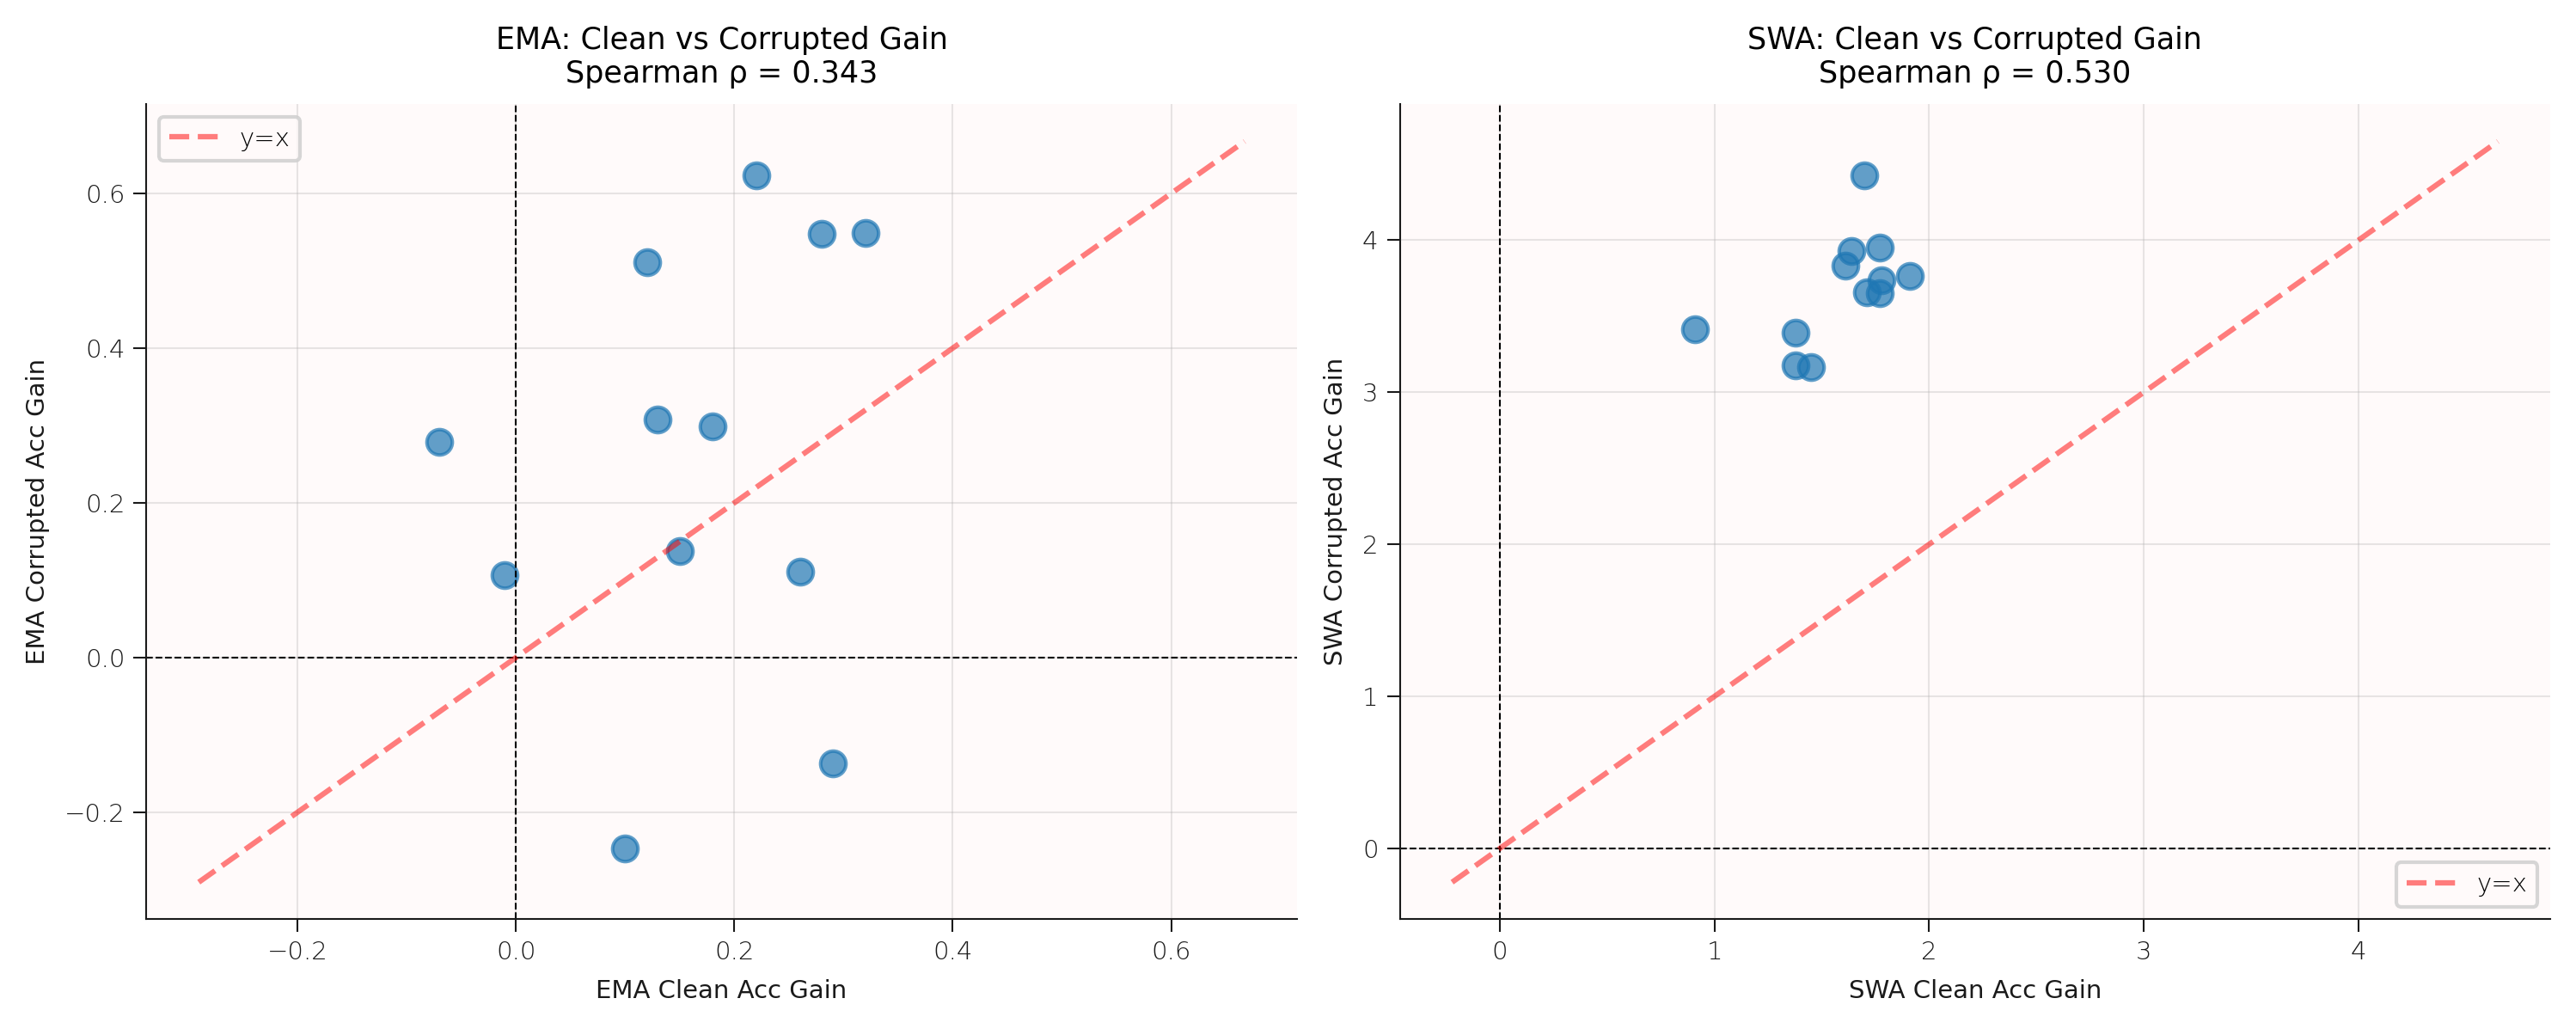

In [14]:
# Scatter: Clean gain vs Corrupted gain for EMA and SWA
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# EMA
ax = axes[0]
x = pivot['ema_clean_acc_gain'].to_numpy()
y = pivot['ema_corrupted_acc_gain'].to_numpy()
ax.scatter(x, y, alpha=0.7, s=50)

# Correlation
r, p = spearmanr(x, y)
ax.set_xlabel('EMA Clean Acc Gain')
ax.set_ylabel('EMA Corrupted Acc Gain')
ax.set_title(f'EMA: Clean vs Corrupted Gain\nSpearman ρ = {r:.3f}')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
ax.grid(True, alpha=0.3)

# Add diagonal line
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'r--', alpha=0.5, label='y=x')
ax.legend()

# SWA
ax = axes[1]
x = pivot['swa_clean_acc_gain'].to_numpy()
y = pivot['swa_corrupted_acc_gain'].to_numpy()
ax.scatter(x, y, alpha=0.7, s=50)

# Correlation
r, p = spearmanr(x, y)
ax.set_xlabel('SWA Clean Acc Gain')
ax.set_ylabel('SWA Corrupted Acc Gain')
ax.set_title(f'SWA: Clean vs Corrupted Gain\nSpearman ρ = {r:.3f}')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
ax.grid(True, alpha=0.3)

# Add diagonal line
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'r--', alpha=0.5, label='y=x')
ax.legend()

plt.tight_layout()
plt.savefig('../report/figures/ema_swa_clean_vs_corrupted_gain.png', dpi=300)
plt.show()

## 6. Per-Run Comparison

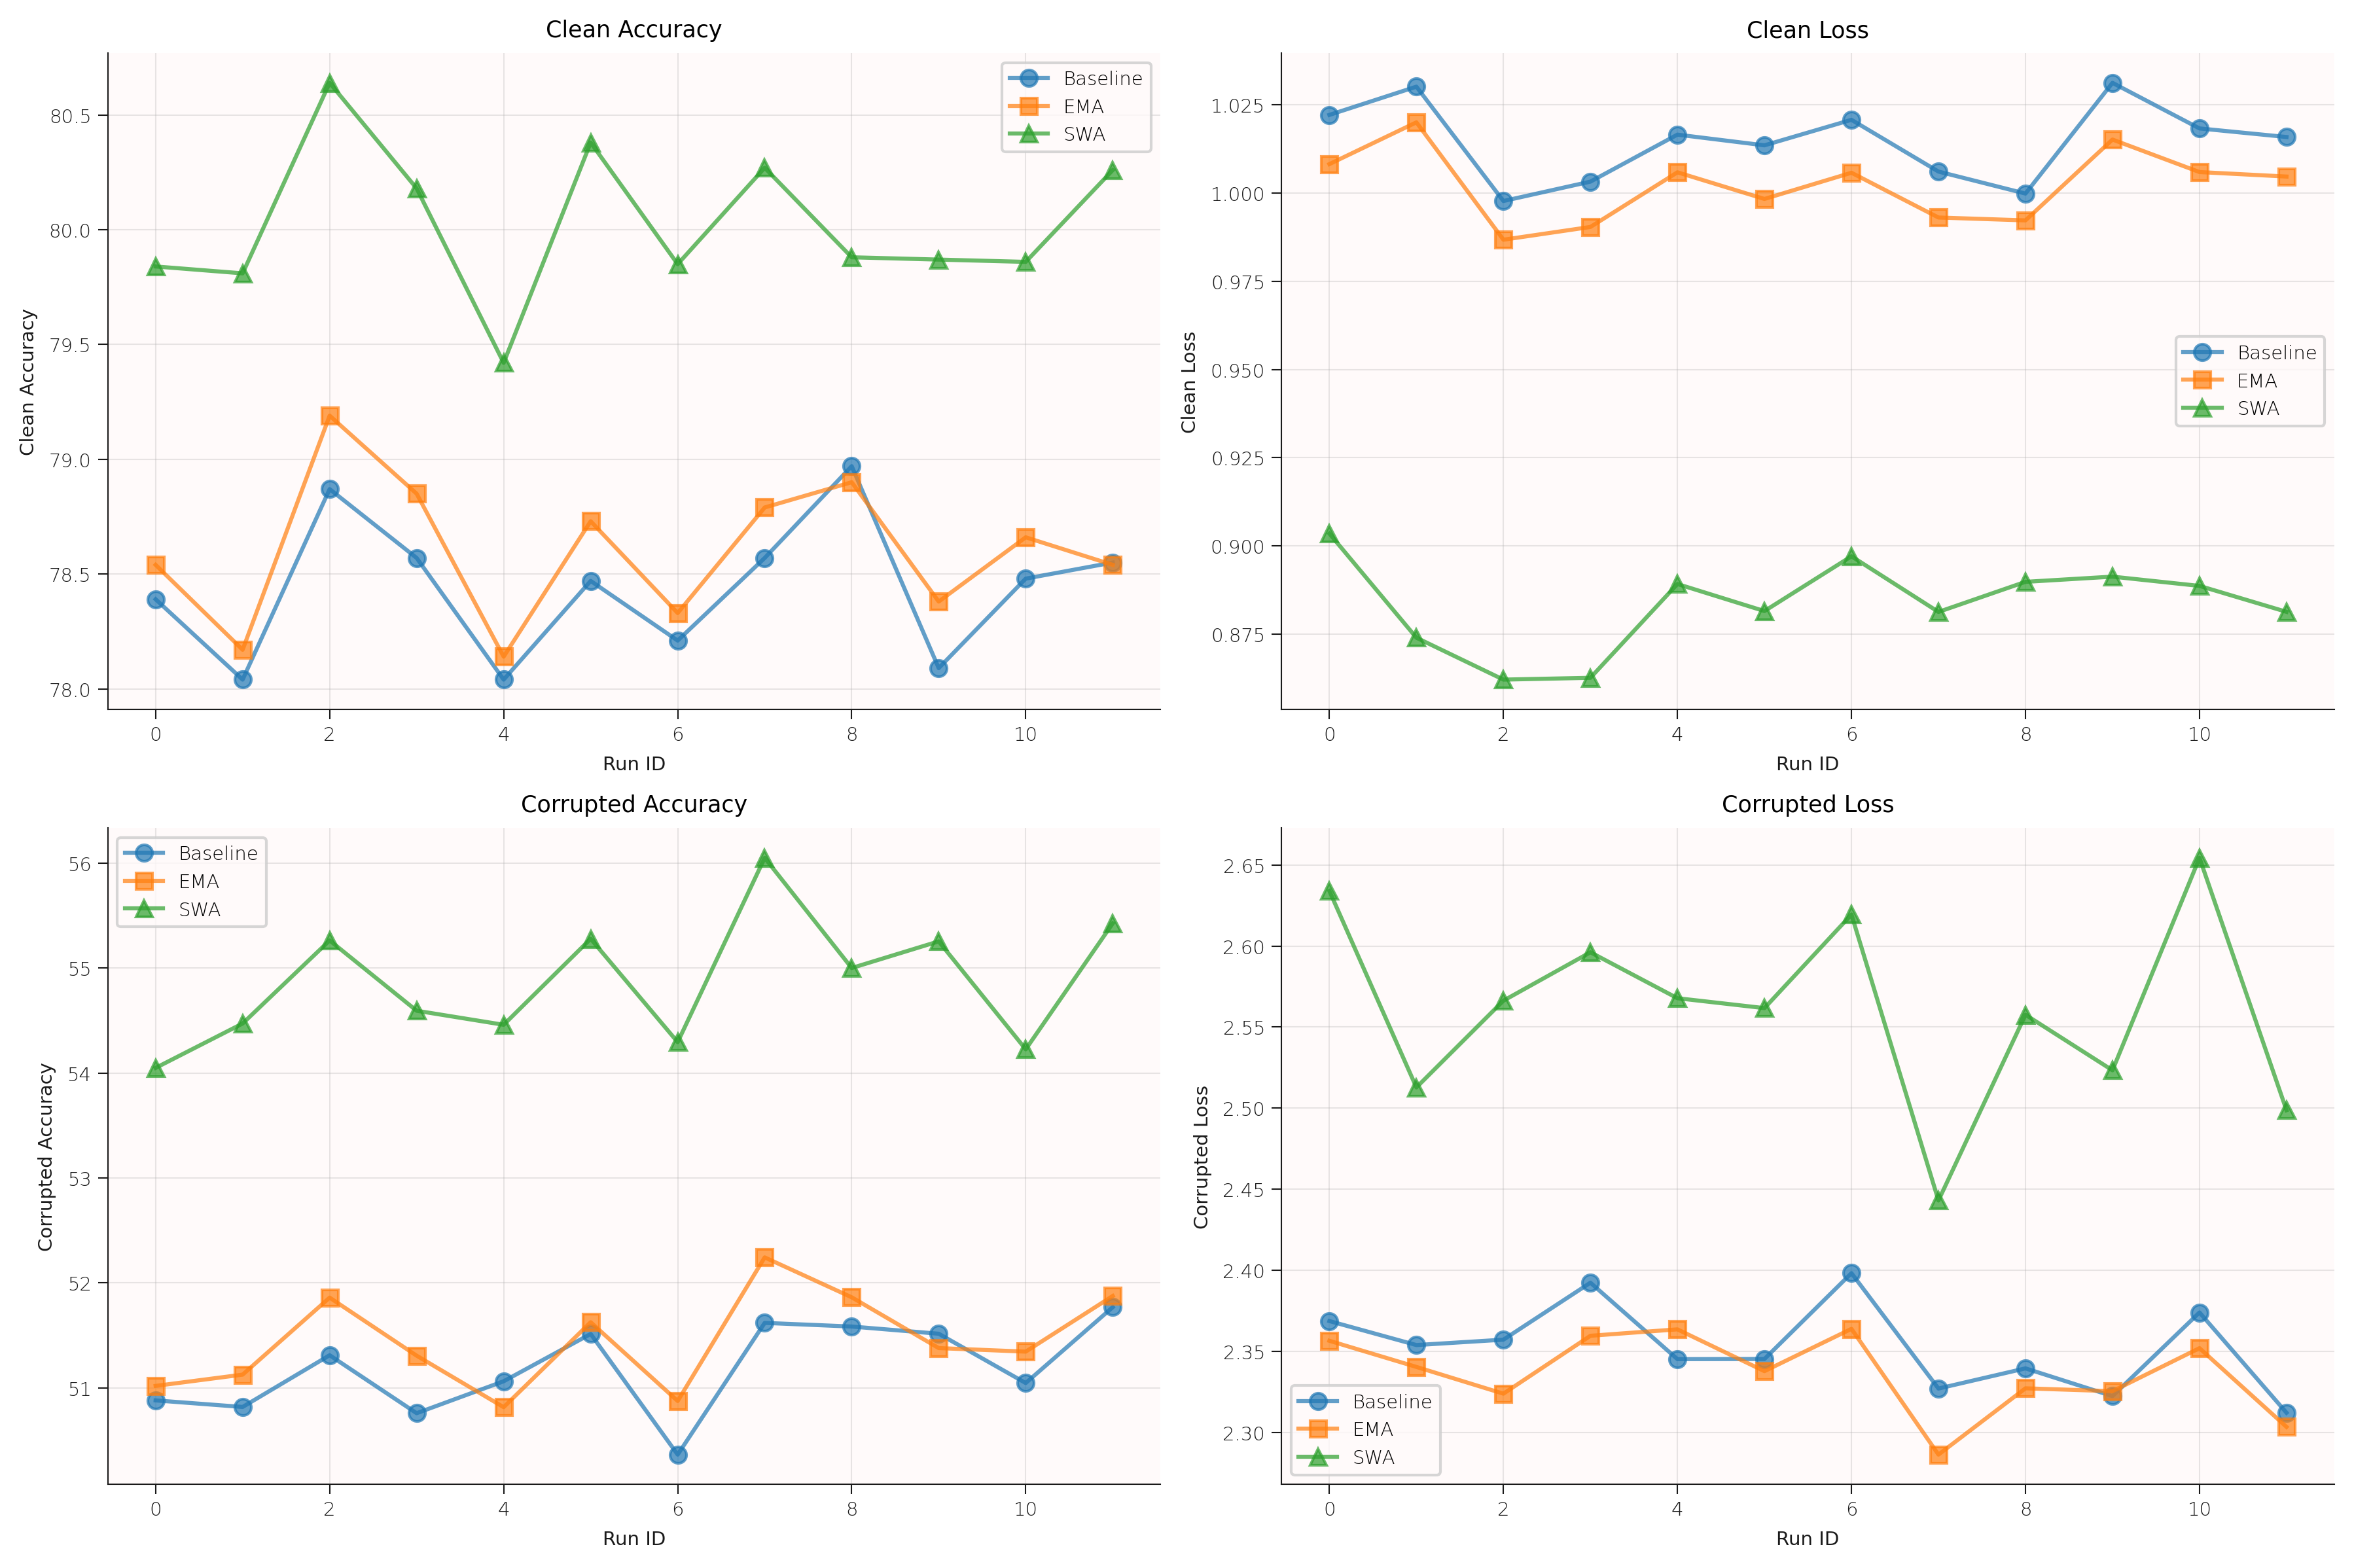

In [15]:
# Line plot showing performance across runs
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics = [
    ('clean_acc', 'Clean Accuracy'),
    ('clean_loss', 'Clean Loss'),
    ('corrupted_acc', 'Corrupted Accuracy'),
    ('corrupted_loss', 'Corrupted Loss')
]

for ax, (metric, title) in zip(axes.flatten(), metrics):
    for model_type, marker, color in [('Baseline', 'o', '#1f77b4'), ('EMA', 's', '#ff7f0e'), ('SWA', '^', '#2ca02c')]:
        model_df = df[df['model_type'] == model_type].sort_values('run_id')
        ax.plot(model_df['run_id'], model_df[metric], marker=marker, label=model_type, color=color, alpha=0.7)
    
    ax.set_xlabel('Run ID')
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../report/figures/ema_swa_per_run.png', dpi=300)
plt.show()

## 7. Summary Statistics

In [16]:
# Create comprehensive summary table
print("=" * 60)
print("EMA/SWA ROBUSTNESS ANALYSIS SUMMARY")
print("=" * 60)

print("\n--- Performance Metrics (Mean ± Std) ---")
print(summary.to_string())

print("\n--- Gains Over Baseline ---")
gain_summary = pd.DataFrame({
    'Metric': ['Clean Acc Gain', 'Clean Loss Gain', 'Corrupted Acc Gain', 'Corrupted Loss Gain'],
    'EMA': [
        f"{pivot['ema_clean_acc_gain'].mean():.4f} ± {pivot['ema_clean_acc_gain'].std():.4f}",
        f"{pivot['ema_clean_loss_gain'].mean():.4f} ± {pivot['ema_clean_loss_gain'].std():.4f}",
        f"{pivot['ema_corrupted_acc_gain'].mean():.4f} ± {pivot['ema_corrupted_acc_gain'].std():.4f}",
        f"{pivot['ema_corrupted_loss_gain'].mean():.4f} ± {pivot['ema_corrupted_loss_gain'].std():.4f}"
    ],
    'SWA': [
        f"{pivot['swa_clean_acc_gain'].mean():.4f} ± {pivot['swa_clean_acc_gain'].std():.4f}",
        f"{pivot['swa_clean_loss_gain'].mean():.4f} ± {pivot['swa_clean_loss_gain'].std():.4f}",
        f"{pivot['swa_corrupted_acc_gain'].mean():.4f} ± {pivot['swa_corrupted_acc_gain'].std():.4f}",
        f"{pivot['swa_corrupted_loss_gain'].mean():.4f} ± {pivot['swa_corrupted_loss_gain'].std():.4f}"
    ]
}).set_index('Metric')
print(gain_summary.to_string())

print("\n--- Robustness Gap (Clean Acc - Corrupted Acc) ---")
print("(Lower = More Robust)")
print(f"Baseline: {pivot['baseline_robustness_gap'].mean():.4f} ± {pivot['baseline_robustness_gap'].std():.4f}")
print(f"EMA:      {pivot['ema_robustness_gap'].mean():.4f} ± {pivot['ema_robustness_gap'].std():.4f}")
print(f"SWA:      {pivot['swa_robustness_gap'].mean():.4f} ± {pivot['swa_robustness_gap'].std():.4f}")

print("\n--- Robustness Gap Improvement vs Baseline ---")
print("(Positive = Better Robustness than Baseline)")
print(f"EMA: {pivot['ema_robustness_improvement'].mean():.4f} ± {pivot['ema_robustness_improvement'].std():.4f}")
print(f"SWA: {pivot['swa_robustness_improvement'].mean():.4f} ± {pivot['swa_robustness_improvement'].std():.4f}")

EMA/SWA ROBUSTNESS ANALYSIS SUMMARY

--- Performance Metrics (Mean ± Std) ---
             Clean Acc       Clean Loss Corrupted Acc   Corrupted Loss  N Runs
Model                                                                         
Baseline  78.44 ± 0.30  1.0146 ± 0.0110  51.19 ± 0.43  2.3530 ± 0.0268      12
EMA       78.60 ± 0.31  1.0022 ± 0.0102  51.45 ± 0.45  2.3367 ± 0.0246      12
SWA       80.02 ± 0.33  0.8835 ± 0.0126  54.86 ± 0.60  2.5613 ± 0.0605      12

--- Gains Over Baseline ---
                                 EMA               SWA
Metric                                                
Clean Acc Gain       0.1642 ± 0.1201   1.5842 ± 0.2701
Clean Loss Gain      0.0124 ± 0.0024   0.1311 ± 0.0118
Corrupted Acc Gain   0.2574 ± 0.2763   3.6743 ± 0.3564
Corrupted Loss Gain  0.0163 ± 0.0172  -0.2083 ± 0.0432

--- Robustness Gap (Clean Acc - Corrupted Acc) ---
(Lower = More Robust)
Baseline: 27.2494 ± 0.4057
EMA:      27.1562 ± 0.3193
SWA:      25.1592 ± 0.4715

--- Robustne

In [17]:
# Compare ratio of corrupted gain to clean gain
# If ratio > 1, corrupted improves more than clean (better robustness)
# If ratio < 1, clean improves more than corrupted (worse robustness)

print("\n--- Corrupted vs Clean Gain Ratio ---")
print("(>1 means corrupted improves more, indicating better robustness benefit)")

ema_ratio = pivot['ema_corrupted_acc_gain'].mean() / pivot['ema_clean_acc_gain'].mean()
swa_ratio = pivot['swa_corrupted_acc_gain'].mean() / pivot['swa_clean_acc_gain'].mean()

print(f"EMA Corrupted/Clean Acc Gain Ratio: {ema_ratio:.4f}")
print(f"SWA Corrupted/Clean Acc Gain Ratio: {swa_ratio:.4f}")


--- Corrupted vs Clean Gain Ratio ---
(>1 means corrupted improves more, indicating better robustness benefit)
EMA Corrupted/Clean Acc Gain Ratio: 1.5677
SWA Corrupted/Clean Acc Gain Ratio: 2.3194
